In [1]:
import pandas as pd
import numpy as np
import datetime
import requests
import io
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

In [2]:
import matplotlib.pyplot as plt

In [36]:
import missingno as msno

In [3]:
bmi = pd.read_csv("bmi.csv")
print(bmi)

   first_name last_name  weight  height    bmi
0        arun   khattri      86    1.86  24.86
1      andrew    ketter      93    1.75  30.37
2         bob    wilson      89    1.82  26.87
3     charlie   desouza      77    1.60  30.08
4         bob    wilson      89    1.82  26.87
5        arun   khattri      86    1.86  24.86
6     charles    darwin      78    1.75  25.47
7      donald     trump      94    1.65  34.53
8       henry   clinton      75    1.62  28.58
9     charles    darwin      78    1.73  26.06
10     andrew    ketter      93    1.72  31.44


## Duplicate Values

In [4]:
# get duplicates across all columns
dup_bmi = bmi.duplicated()
# counts of duplicates
print(dup_bmi.sum())

2


In [5]:
print(bmi[dup_bmi])

  first_name last_name  weight  height    bmi
4        bob    wilson      89    1.82  26.87
5       arun   khattri      86    1.86  24.86


### Properly calibrate duplicates

In [6]:
col_names = ["first_name", "last_name", "weight"]
dup_bmi_names = bmi.duplicated(subset=col_names, keep=False)

# counts of duplicates
print(dup_bmi_names.sum())

8


In [7]:
print(bmi[dup_bmi_names])

   first_name last_name  weight  height    bmi
0        arun   khattri      86    1.86  24.86
1      andrew    ketter      93    1.75  30.37
2         bob    wilson      89    1.82  26.87
4         bob    wilson      89    1.82  26.87
5        arun   khattri      86    1.86  24.86
6     charles    darwin      78    1.75  25.47
9     charles    darwin      78    1.73  26.06
10     andrew    ketter      93    1.72  31.44


In [8]:
print(bmi[dup_bmi_names].sort_values(by="first_name"))

   first_name last_name  weight  height    bmi
1      andrew    ketter      93    1.75  30.37
10     andrew    ketter      93    1.72  31.44
0        arun   khattri      86    1.86  24.86
5        arun   khattri      86    1.86  24.86
2         bob    wilson      89    1.82  26.87
4         bob    wilson      89    1.82  26.87
6     charles    darwin      78    1.75  25.47
9     charles    darwin      78    1.73  26.06


In [9]:
# keep one of complete duplicate values
bmi.drop_duplicates(keep="first", inplace=True)
print(bmi)

   first_name last_name  weight  height    bmi
0        arun   khattri      86    1.86  24.86
1      andrew    ketter      93    1.75  30.37
2         bob    wilson      89    1.82  26.87
3     charlie   desouza      77    1.60  30.08
6     charles    darwin      78    1.75  25.47
7      donald     trump      94    1.65  34.53
8       henry   clinton      75    1.62  28.58
9     charles    darwin      78    1.73  26.06
10     andrew    ketter      93    1.72  31.44


In [10]:
col_names = ["first_name", "last_name", "weight"]
dup_bmi_names = bmi.duplicated(subset=col_names, keep=False)
print(dup_bmi_names)

0     False
1      True
2     False
3     False
6      True
7     False
8     False
9      True
10     True
dtype: bool


In [11]:
print(bmi[dup_bmi_names])

   first_name last_name  weight  height    bmi
1      andrew    ketter      93    1.75  30.37
6     charles    darwin      78    1.75  25.47
9     charles    darwin      78    1.73  26.06
10     andrew    ketter      93    1.72  31.44


### Remove duplicates

In [12]:
# remove other duplicates
summaries = {"height": "mean"}
bmi_grp = bmi.groupby(by=col_names).agg(summaries).reset_index()
print(bmi_grp)

  first_name last_name  weight  height
0     andrew    ketter      93   1.735
1       arun   khattri      86   1.860
2        bob    wilson      89   1.820
3    charles    darwin      78   1.740
4    charlie   desouza      77   1.600
5     donald     trump      94   1.650
6      henry   clinton      75   1.620


In [13]:
bmi_grp["bmi"] = bmi_grp["weight"] / (bmi_grp["height"] ** 2)
print(f"\n{bmi_grp}")


  first_name last_name  weight  height        bmi
0     andrew    ketter      93   1.735  30.894701
1       arun   khattri      86   1.860  24.858365
2        bob    wilson      89   1.820  26.868736
3    charles    darwin      78   1.740  25.762981
4    charlie   desouza      77   1.600  30.078125
5     donald     trump      94   1.650  34.527089
6      henry   clinton      75   1.620  28.577961


## Membership constraints

In [14]:
# Membership constraints
study_data_dict = {
    "name": ["beth", "ignatius", "paul", "helen", "jennifer", "kennedy", "keith"],
    "birthday": [
        "2019-10-20",
        "2020-07-08",
        "2019-08-12",
        "2019-03-17",
        "2019-12-17",
        "2020-04-27",
        "2019-04-19",
    ],
    "blood_type": ["B-", "A-", "O+", "O-", "Z+", "A+", "AB+"],
}

study_data = pd.DataFrame.from_dict(study_data_dict)
print(study_data)

       name    birthday blood_type
0      beth  2019-10-20         B-
1  ignatius  2020-07-08         A-
2      paul  2019-08-12         O+
3     helen  2019-03-17         O-
4  jennifer  2019-12-17         Z+
5   kennedy  2020-04-27         A+
6     keith  2019-04-19        AB+


In [15]:
study_data["birthday"] = pd.to_datetime(study_data["birthday"])
study_data["blood_type"] = study_data["blood_type"].astype("category")
print(study_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   name        7 non-null      object        
 1   birthday    7 non-null      datetime64[ns]
 2   blood_type  7 non-null      category      
dtypes: category(1), datetime64[ns](1), object(1)
memory usage: 623.0+ bytes
None


In [16]:
categories = pd.DataFrame(
    {"blood_type": ["O-", "O+", "A-", "A+", "B+", "B-", "AB+", "AB-"]}
)
print(categories)

  blood_type
0         O-
1         O+
2         A-
3         A+
4         B+
5         B-
6        AB+
7        AB-


### Finding inconsistent categories

In [17]:
# finding inconsistent categories
inconsistent_cats = set(study_data["blood_type"]).difference(categories["blood_type"])
print(inconsistent_cats)

{'Z+'}


In [18]:
# get and print rows with inconsistent categories
inconsistent_rows = study_data["blood_type"].isin(inconsistent_cats)
print(study_data[inconsistent_rows])

       name   birthday blood_type
4  jennifer 2019-12-17         Z+


In [18]:
# dropping inconsistent categories
consistent_data = study_data[~inconsistent_rows]
print(consistent_data)

       name   birthday blood_type
0      beth 2019-10-20         B-
1  ignatius 2020-07-08         A-
2      paul 2019-08-12         O+
3     helen 2019-03-17         O-
5   kennedy 2020-04-27         A+
6     keith 2019-04-19        AB+


In [19]:
demographics = pd.read_csv("household_survey.csv")
print(demographics.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   family_size       29 non-null     int64 
 1   household_income  29 non-null     int64 
 2   owned_house       29 non-null     object
 3   rented_house      29 non-null     object
 4   owned_vehicle     29 non-null     object
 5   vehicle_type      29 non-null     object
dtypes: int64(2), object(4)
memory usage: 1.5+ KB
None


In [20]:
print(demographics.head())

   family_size  household_income owned_house rented_house owned_vehicle  \
0            5            168214          no          yes           yes   
1            3            155100         yes           no           yes   
2            5             55185          no          yes           yes   
3            2            148271         yes           no            no   
4            6            226867          no          yes           yes   

  vehicle_type  
0          car  
1        sedan  
2       scooty  
3         bike  
4          suv  


In [21]:
# converting to category column
for col in demographics.select_dtypes(include="object").columns:
    demographics[col] = demographics[col].astype("category")

print(demographics.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   family_size       29 non-null     int64   
 1   household_income  29 non-null     int64   
 2   owned_house       29 non-null     category
 3   rented_house      29 non-null     category
 4   owned_vehicle     29 non-null     category
 5   vehicle_type      29 non-null     category
dtypes: category(4), int64(2)
memory usage: 1.2 KB
None


In [22]:
# creating categories out of data
group_names = ["low", "medium", "high"]

demographics["inc_grp"] = pd.qcut(
    demographics["household_income"], q=3, labels=group_names
)
# (49080.999, 97751.667] < (97751.667, 167651.0] < (167651.0, 247614.0]

print(demographics[["inc_grp", "household_income"]].head())

  inc_grp  household_income
0    high            168214
1  medium            155100
2     low             55185
3  medium            148271
4    high            226867


In [23]:
# or can be done by defining own cuts
ranges = [0, 100000, 200000, np.inf]
group_names = ["low", "medium", "high"]

demographics["income_group"] = pd.cut(
    demographics["household_income"], bins=ranges, labels=group_names
)

print(demographics[["inc_grp", "household_income", "income_group"]].head())

  inc_grp  household_income income_group
0    high            168214       medium
1  medium            155100       medium
2     low             55185          low
3  medium            148271       medium
4    high            226867         high


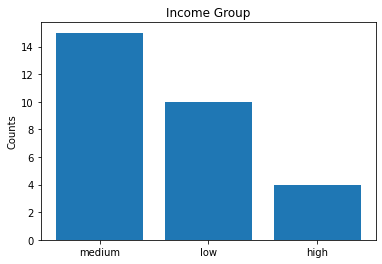

In [24]:
inc_grp_counts = demographics['income_group'].value_counts()
fig, ax = plt.subplots()
ax.bar(inc_grp_counts.index, inc_grp_counts.values)
ax.set(title="Income Group",
       ylabel="Counts")
plt.show()

In [25]:
# collapsing data into category
# map categories to fewer ones
mapping = {
    "car": "4wheeler",
    "sedan": "4wheeler",
    "suv": "4wheeler",
    "scooty": "2wheeler",
    "bike": "2wheeler",
}
demographics["veh_cat"] = demographics["vehicle_type"].replace(mapping)

In [26]:
print(demographics["veh_cat"].unique())

['4wheeler' '2wheeler']


In [27]:
print(demographics["vehicle_type"].unique())

[car, sedan, scooty, bike, suv]
Categories (5, object): [car, sedan, scooty, bike, suv]


In [28]:
veh_counts = demographics['veh_cat'].value_counts()

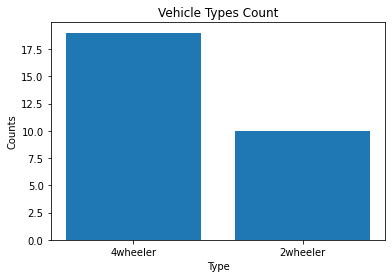

In [29]:
fig, ax = plt.subplots()
ax.bar(veh_counts.index, veh_counts.values)
ax.set(title="Vehicle Types Count",
      xlabel='Type',
      ylabel='Counts')
plt.show()

## Cross Field Validation

In [30]:
banking = pd.read_csv('banking.csv', parse_dates=[1,5,6])
banking.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   cust_id           100 non-null    object        
 1   birth_date        100 non-null    datetime64[ns]
 2   age               100 non-null    int64         
 3   acct_amount       100 non-null    float64       
 4   inv_amount        100 non-null    int64         
 5   account_opened    100 non-null    datetime64[ns]
 6   last_transaction  100 non-null    datetime64[ns]
 7   fund_A            100 non-null    float64       
 8   fund_B            100 non-null    float64       
 9   fund_C            100 non-null    float64       
 10  fund_D            100 non-null    float64       
dtypes: datetime64[ns](3), float64(5), int64(2), object(1)
memory usage: 8.7+ KB


In [31]:
fund_cols = ['fund_A', 'fund_B', 'fund_C', 'fund_D']
# find rows where fund_cols row sum == inv_amount
inv_equal_funds = banking[fund_cols].sum(axis=1) == banking['inv_amount']

In [32]:
# how many rows?
inv_equal_funds.sum()

92

In [33]:
inconsistent_data = banking[~inv_equal_funds]
print(inconsistent_data.shape[0])

8


In [34]:
# find any inconsistent data in age
today = datetime.date.today()
ages_manual = today.year - banking['birth_date'].dt.year
age_equal = ages_manual == banking['age']
inconsistent_age = banking[~age_equal]
print("Inconsistent age: {inconsistent_age.shape[0]}")

Inconsistent age: {inconsistent_age.shape[0]}


In [35]:
url = "https://raw.githubusercontent.com/wblakecannon/DataCamp/master/10-cleaning-data-in-python/_datasets/airquality.csv"
data = requests.get(url).content
airquality = pd.read_csv(io.StringIO(data.decode('utf-8')))
airquality.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Ozone    116 non-null    float64
 1   Solar.R  146 non-null    float64
 2   Wind     153 non-null    float64
 3   Temp     153 non-null    int64  
 4   Month    153 non-null    int64  
 5   Day      153 non-null    int64  
dtypes: float64(3), int64(3)
memory usage: 7.3 KB


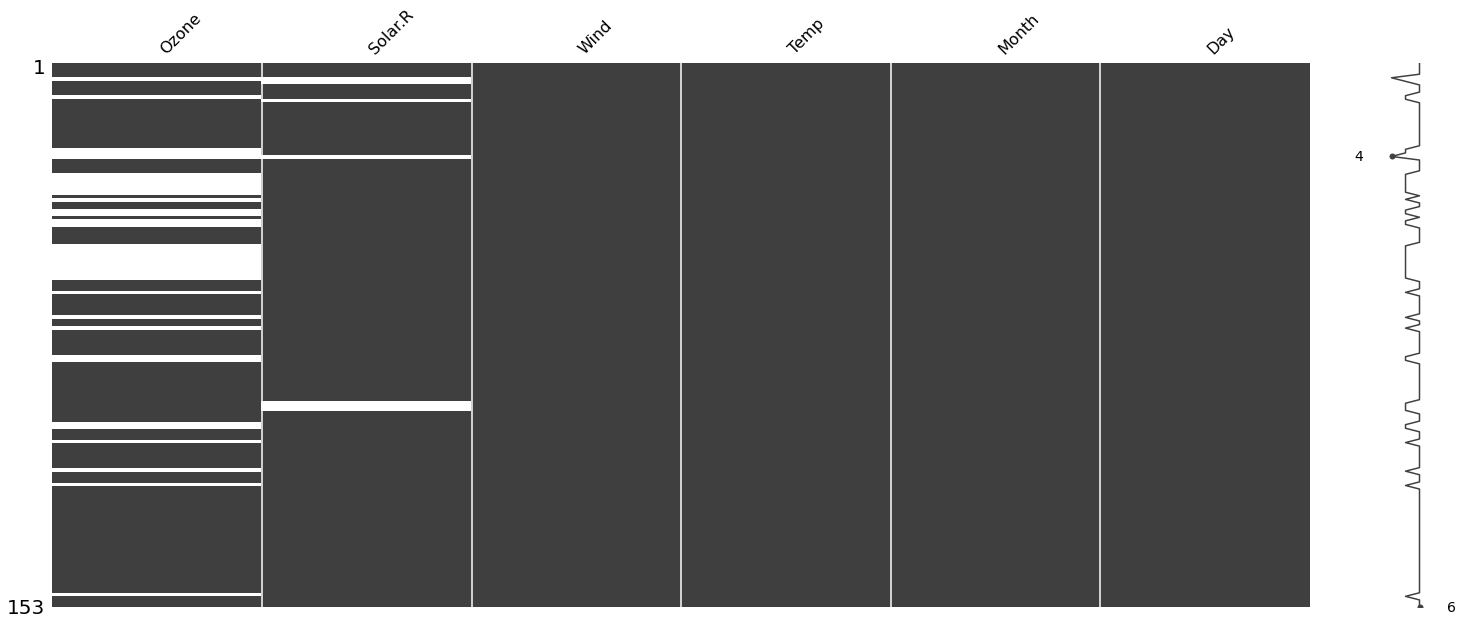

In [37]:
# visualize missing values
msno.matrix(airquality)
plt.show()

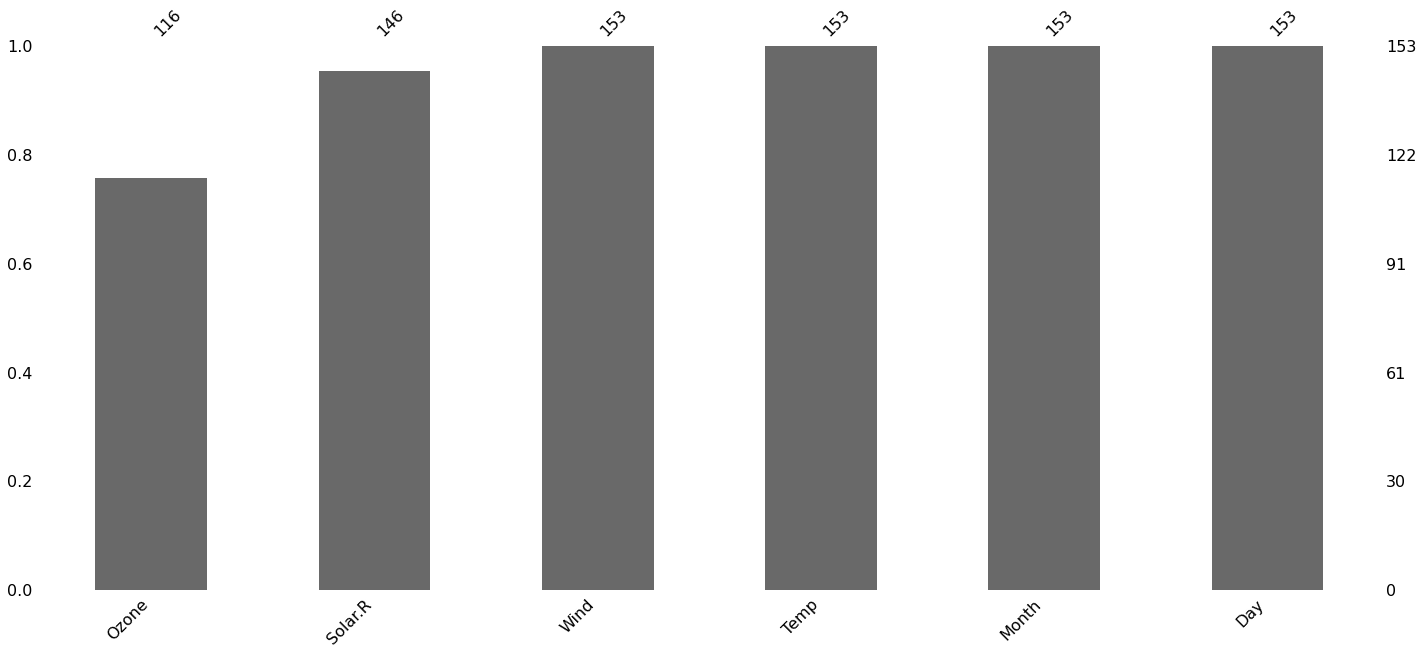

In [38]:
msno.bar(airquality)
plt.show()

In [39]:
# isolate missing and complete values aside
missing = airquality[airquality['Ozone'].isna()]
complete = airquality[~airquality['Ozone'].isna()]

In [40]:
missing.describe()

Ozone     Solar.R       Wind       Temp      Month        Day
count    0.0   35.000000  37.000000  37.000000  37.000000  37.000000
mean     NaN  189.514286  10.256757  77.918919   6.351351  16.648649
std      NaN   87.694782   3.385142   9.531755   0.977986   9.286239
min      NaN   31.000000   1.700000  56.000000   5.000000   1.000000
25%      NaN  131.000000   8.000000  75.000000   6.000000  10.000000
50%      NaN  194.000000   9.700000  79.000000   6.000000  15.000000
75%      NaN  261.500000  12.600000  84.000000   7.000000  25.000000
max      NaN  332.000000  16.600000  93.000000   9.000000  30.000000

In [41]:
complete.describe()

Ozone     Solar.R        Wind        Temp       Month         Day
count  116.000000  111.000000  116.000000  116.000000  116.000000  116.000000
mean    42.129310  184.801802    9.862069   77.870690    7.198276   15.534483
std     32.987885   91.152302    3.574856    9.485486    1.475715    8.750087
min      1.000000    7.000000    2.300000   57.000000    5.000000    1.000000
25%     18.000000  113.500000    7.400000   71.000000    6.000000    8.000000
50%     31.500000  207.000000    9.700000   79.000000    7.000000   16.000000
75%     63.250000  255.500000   11.500000   85.000000    8.250000   22.000000
max    168.000000  334.000000   20.700000   97.000000    9.000000   31.000000

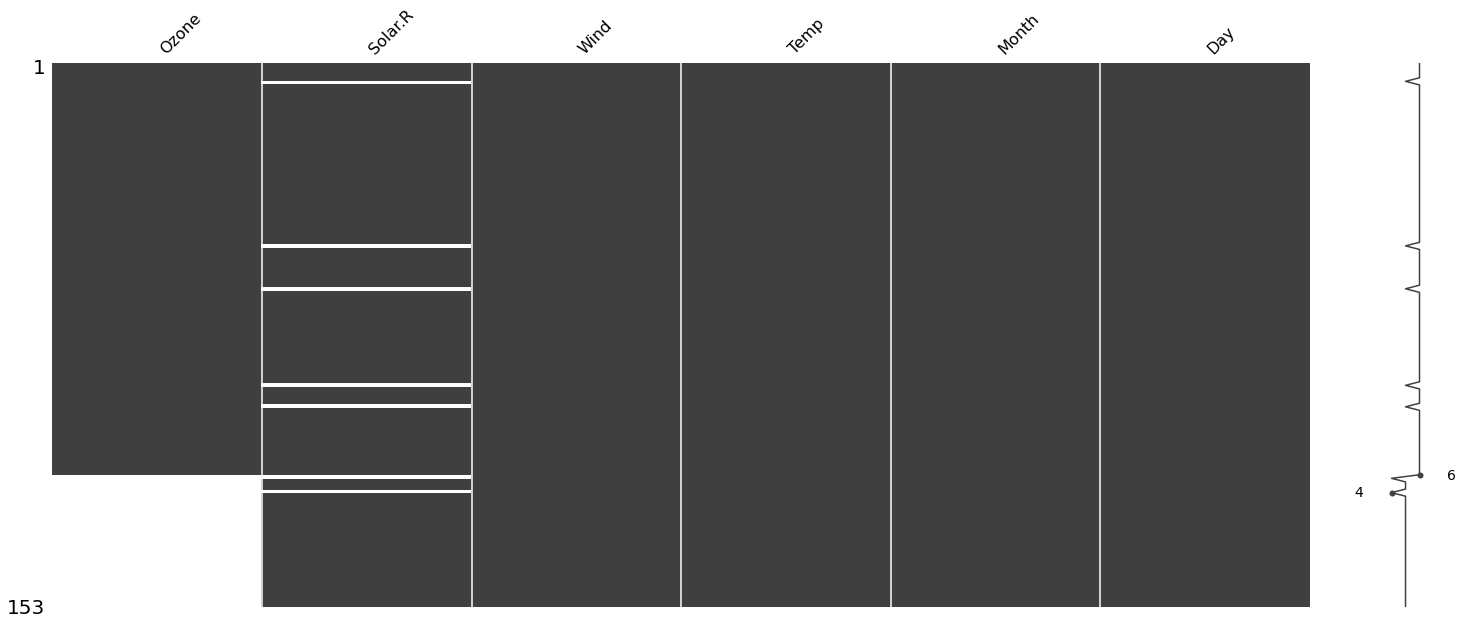

In [42]:
# finding out missing values pattern
sorted_airquality = airquality.sort_values(by='Ozone')
msno.matrix(sorted_airquality)
plt.show()

It seems there was some issue with recording high ozone values.

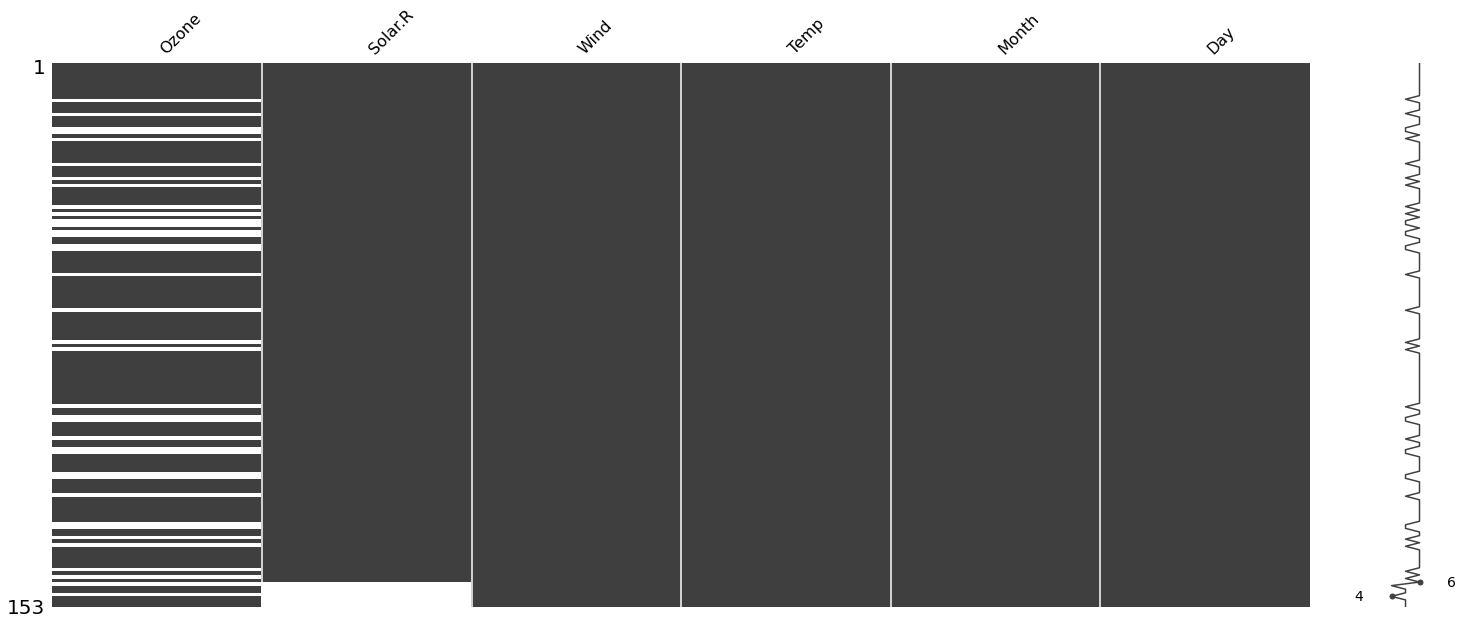

In [43]:
sorted_airquality = airquality.sort_values(by='Solar.R')
msno.matrix(sorted_airquality)
plt.show()

It is also true for higher Solar.R values

In [44]:
# number of missing values
airquality.isna().sum()

Ozone      37
Solar.R     7
Wind        0
Temp        0
Month       0
Day         0
dtype: int64

## Comparing Strings

In [45]:
# compare reeding vs reading
fuzz.WRatio('Reeding', 'Reading')

86

0 is no match - 100 is perfect match

In [46]:
# Partial strings 
fuzz.WRatio('Houston Rockets', 'Rockets')

90

In [47]:
# Partial strings and different orderings
fuzz.WRatio('Houston Rockets vs Los Angeles Lakers', 'Lakers vs Rockets')

86

In [73]:
# Comparison with arrays

In [48]:
string = 'Houston Rockets vs Los Angeles Lakers'
choices = pd.Series(['Rockets vs Lakers', 'Lakers vs Rockets', 'Houson vs Los Angeles',
                     'Heat vs Bulls'])
process.extract(string, choices, limit=2)

[('Rockets vs Lakers', 86, 0), ('Lakers vs Rockets', 86, 1)]

### Collapsing categories with string matching

In [54]:
survey = pd.read_csv("survey.csv")
survey.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   dist    11 non-null     object
 1   state   11 non-null     object
 2   cases   11 non-null     int64 
 3   deaths  11 non-null     int64 
dtypes: int64(2), object(2)
memory usage: 480.0+ bytes


In [55]:
survey.state.unique()

array(['Uttar Pradesh', 'Utar PRadesh', 'Uttar Padesh', 'Utar Padesh',
       'Madhya Pradesh', 'Madya Padesh', 'Madya Pradesh'], dtype=object)

In [51]:
state_cats = pd.DataFrame({"state": ["Uttar Pradesh", "Madhya Pradesh"]})
state_cats

state
0   Uttar Pradesh
1  Madhya Pradesh

In [56]:
matches = process.extract("Uttar Pradesh", survey['state'], limit=survey.shape[0])
matches

[('Uttar Pradesh', 100, 0),
 ('Uttar Pradesh', 100, 3),
 ('Uttar Pradesh', 100, 5),
 ('Utar PRadesh', 96, 1),
 ('Uttar Padesh', 96, 2),
 ('Utar PRadesh', 96, 4),
 ('Utar Padesh', 92, 6),
 ('Madya Pradesh', 69, 10),
 ('Madhya Pradesh', 67, 7),
 ('Madhya Pradesh', 67, 9),
 ('Madya Padesh', 64, 8)]

In [57]:
matches = process.extract("Madhya Pradesh", survey['state'], limit=survey.shape[0])
matches

[('Madhya Pradesh', 100, 7),
 ('Madhya Pradesh', 100, 9),
 ('Madya Pradesh', 96, 10),
 ('Madya Padesh', 92, 8),
 ('Utar PRadesh', 70, 1),
 ('Utar PRadesh', 70, 4),
 ('Uttar Pradesh', 67, 0),
 ('Uttar Pradesh', 67, 3),
 ('Uttar Pradesh', 67, 5),
 ('Utar Padesh', 64, 6),
 ('Uttar Padesh', 62, 2)]

In [58]:
# collapsing all of the state
# for each correct category
for state in state_cats['state']:
    # find potential matches
    matches = process.extract(state, survey['state'], limit=survey.shape[0])
    # for each potential match match
    for potential_match in matches:
        # if high similarity score
        if potential_match[1] >= 90:
            # replace typo with correct category
            survey.loc[survey['state'] == potential_match[0], 'state'] = state

In [59]:
survey.state.unique()

array(['Uttar Pradesh', 'Madhya Pradesh'], dtype=object)